In [50]:
import numpy as np
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import NuSVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [51]:
# H10.2: Regression with the ν-SVR
# upload csv files manually since they are small and drive mount not working
uploaded = files.upload()

Saving ValidationRidge.csv to ValidationRidge (2).csv
Saving TrainingRidge.csv to TrainingRidge (2).csv


In [52]:
# prepare datasets
# set nu_symbol for later
nu_symbol = "ν"

df_train = pd.read_csv("TrainingRidge.csv")
df_valid = pd.read_csv("ValidationRidge.csv")

x1_t = df_train['x1'].values # shape: (200,)
x2_t = df_train['x2'].values # shape: (200,)
X_train = df_train[['x1', 'x2']].values # shape: (200, 2)
y_train = df_train['obs'].values # shape: (200,)

x1_v = df_valid['x1'].values # shape: (1476,)
x2_v = df_valid['x2'].values # shape: (1476,)
X_valid = df_valid[['x1', 'x2']].values # shape: (1476, 2)
y_valid = df_valid['dens'].values # shape: (1476,)

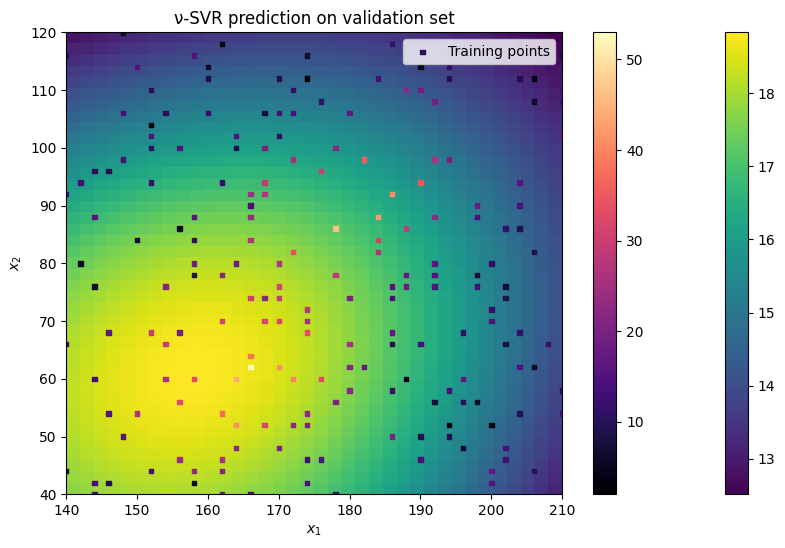

In [53]:
# (a) train the nu-SVR on the training set with standard parameters
model1 = NuSVR(C=1.0, kernel="rbf", gamma="scale")
model1.fit(X_train, y_train)

y_pred = model1.predict(X_valid) # shape: (1476,)

# plot the model prediction for the validation set
x1_n = len(np.unique(x1_v)) # length: 36
x2_n = len(np.unique(x2_v)) # length: 41

x1_v_grid = x1_v.reshape(x2_n, x1_n) # shape: (41, 36)
x2_v_grid = x2_v.reshape(x2_n, x1_n)
y_pred_grid = y_pred.reshape(x2_n, x1_n)

plt.figure(figsize=(10, 6))
im1 = plt.imshow(y_pred_grid, origin='lower', cmap='viridis',
            extent=[x1_v_grid.min(), x1_v_grid.max(), x2_v_grid.min(), x2_v_grid.max()], aspect='auto')
plt.title(f'{nu_symbol}-SVR prediction on validation set')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar(im1)

# add the data points from the training set in the same plot
sc1 = plt.scatter(X_train[:, 0], X_train[:, 1], s=10, c=y_train, cmap='magma', marker='s', label='Training points')
plt.legend(loc='upper right')
plt.colorbar(sc1)

plt.show()

Mean squared error: 65.66


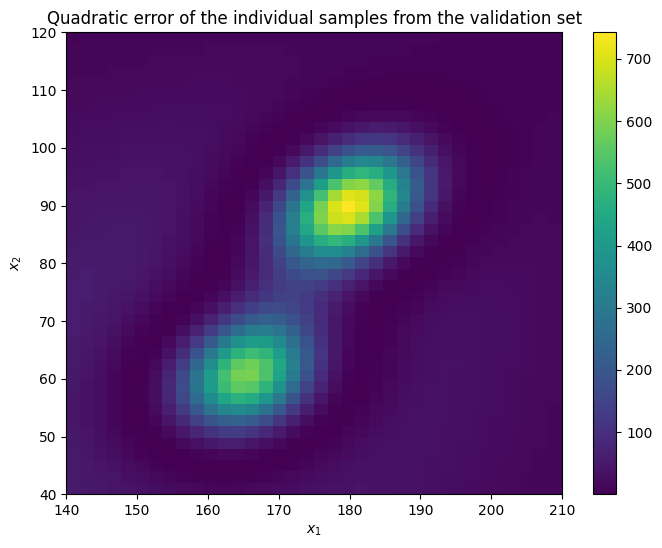

In [99]:
# compute MSE between model prediction and true labels of the validation set
mse = mean_squared_error(y_pred, y_valid)
print(f"Mean squared error: {mse:.2f}")

# plot heatmap of the quadratic error of the individual samples from the validation set
quad_error = (y_pred - y_valid)**2 # shape: (1476,)
quad_error_grid = quad_error.reshape(x2_n, x1_n) # shape: (41, 36)

plt.figure(figsize=(8, 6))
im2 = plt.imshow(quad_error_grid, origin='lower', cmap='viridis',
            extent=[x1_v_grid.min(), x1_v_grid.max(), x2_v_grid.min(), x2_v_grid.max()], aspect='auto')
plt.title('Quadratic error of the individual samples from the validation set')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar(im2)
plt.show()

In [75]:
# (b) perform 10-fold cross-validation with a ν-SVR with ν=0.5
gamma_range = [2**i for i in range(-12, 1)]
C_range = [2**j for j in range(-2, 13)]

kf = KFold(n_splits=10, shuffle=True, random_state=42)
mse_matrix = np.zeros((len(gamma_range), len(C_range))) # shape: (13, 15)

for i, gamma in enumerate(gamma_range):
  for j, C in enumerate(C_range):
    mse_folds = []
    for train_idx, test_idx in kf.split(X_train):
      X_t, X_v = X_train[train_idx], X_train[test_idx]
      y_t, y_v = y_train[train_idx], y_train[test_idx]

      model2 = NuSVR(C=C, gamma=gamma, nu=0.5, kernel="rbf")
      model2.fit(X_t, y_t)

      y_v_pred = model2.predict(X_v)
      mse = mean_squared_error(y_v_pred, y_v)
      mse_folds.append(mse)

    mse_matrix[i, j] = np.mean(mse_folds) # mean over 10 folds

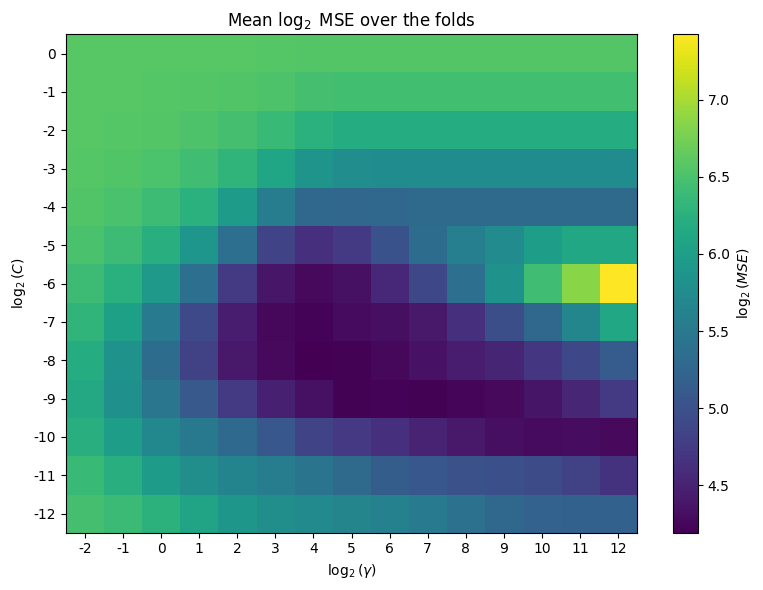

In [79]:
# plot the resulting mean (test set) MSE over the folds
log_mse_matrix = np.log2(mse_matrix)
plt.figure(figsize=(8, 6))
im3 = plt.imshow(log_mse_matrix, origin='lower', cmap='viridis', aspect='auto')
plt.title('Mean $\log_2$ MSE over the folds')
plt.xlabel('$\log_2(\gamma)$')
plt.ylabel('$\log_2(C)$')

C_exp = list(range(-2, 13))
gamma_exp = list(range(-12, 1))

plt.xticks(ticks=np.arange(len(C_exp)), labels=C_exp)
plt.yticks(ticks=np.arange(len(gamma_exp)), labels=gamma_exp)

cbar = plt.colorbar(im3)
cbar.set_label('$\log_2(MSE)$')
plt.tight_layout()
plt.show()

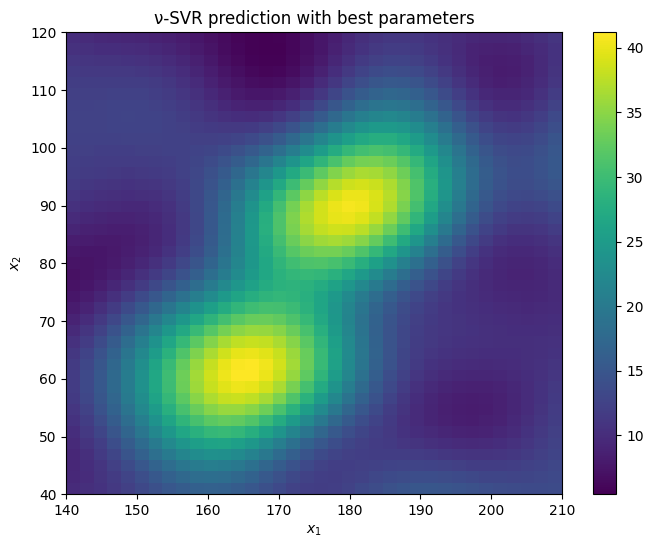

In [94]:
# (c) Extract the best parameter combination C and ν
min_idx = np.unravel_index(np.argmin(mse_matrix), mse_matrix.shape)
i_min, j_min = min_idx
best_gamma = gamma_range[i_min]
best_C = C_range[j_min]

model3 = NuSVR(C=best_C, kernel="rbf", gamma=best_gamma)
model3.fit(X_train, y_train)

y_best_pred = model3.predict(X_valid) # shape: (1476,)
y_best_pred_grid = y_best_pred.reshape(x2_n, x1_n)

plt.figure(figsize=(8, 6))
im4 = plt.imshow(y_best_pred_grid, origin='lower', cmap='viridis',
            extent=[x1_v_grid.min(), x1_v_grid.max(), x2_v_grid.min(), x2_v_grid.max()], aspect='auto')
plt.title(f'{nu_symbol}-SVR prediction with best parameters')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar(im4)
plt.show()

Mean squared error with best parameters: 2.72


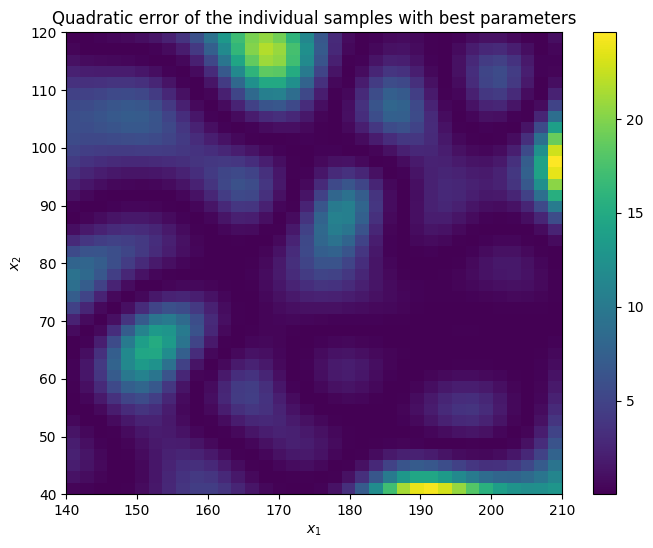

In [101]:
best_mse = mean_squared_error(y_best_pred, y_valid)
print(f"Mean squared error with best parameters: {best_mse:.2f}")

# plot heatmap of the quadratic error of the individual samples from the validation set
best_quad_error = (y_best_pred - y_valid)**2 # shape: (1476,)
best_quad_error_grid = best_quad_error.reshape(x2_n, x1_n) # shape: (41, 36)

plt.figure(figsize=(8, 6))
im5 = plt.imshow(best_quad_error_grid, origin='lower', cmap='viridis',
            extent=[x1_v_grid.min(), x1_v_grid.max(), x2_v_grid.min(), x2_v_grid.max()], aspect='auto')
plt.title('Quadratic error of the individual samples with best parameters')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar(im5)
plt.show()